# Space Invaders with Reinfrocement Learning

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import ale_py
import torch.nn as nn
import torch.optim as optim
from collections import deque
import json
import time

# Visualise Environment 

In [4]:
def render_game_frame(obs, window_width=700, window_height=900):
    # Ensure the input is RGB
    if len(obs.shape) == 3 and obs.shape[2] == 3:  # Confirm RGB
        frame = obs
    else:
        raise ValueError("Expected RGB frame for rendering.")

    # Resize the frame
    frame_height, frame_width = obs.shape[:2]
    aspect_ratio = frame_width / frame_height

    if window_width / aspect_ratio <= window_height:
        new_width = window_width
        new_height = int(window_width / aspect_ratio)
    else:
        new_height = window_height
        new_width = int(window_height * aspect_ratio)

    resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Center the resized frame on a black background
    canvas = np.zeros((window_height, window_width, 3), dtype=np.uint8)
    y_offset = (window_height - new_height) // 2
    x_offset = (window_width - new_width) // 2
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_frame

    # Display the resized frame
    cv2.imshow('Space Invaders', canvas)
    cv2.waitKey(1)

# Noisy Nets

In [5]:
class NoisyLinear(nn.Module):
    """
        Formulas from: 
        M. Fortunato et al., "Noisy Networks for Exploration." arXiv preprint arXiv:1706.10295, 2017.

        Noisy Linear Layer:
        y = (W_mu + W_sigma * epsilon_w) * x + (b_mu + b_sigma * epsilon_b)
        
        (W_mu + W_sigma * epsilon_w) = weight
        (b_mu + b_sigma * epsilon_b) = bias
        
        Gaussian Noise:
        w_epsilon = f(epsilon_in) * f(epsilon_out)
        b_epsilon = f(epsilon_out)
        
        f(x) = sign(x) * sqrt(|x|)
        
    """
    def __init__(self, input_dim, output_dim, noise_scale = 0.5):
        super(NoisyLinear, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.noise_scale = noise_scale
        
        self.w_mu = nn.Parameter(torch.empty(output_dim, input_dim))
        self.w_sigma = nn.Parameter(torch.empty(output_dim, input_dim))
        self.b_mu = nn.Parameter(torch.empty(output_dim))
        self.b_sigma = nn.Parameter(torch.empty(output_dim))
        
        self.register_buffer("w_epsilon", torch.empty(output_dim, input_dim))
        self.register_buffer("b_epsilon", torch.empty(output_dim))

        mu_bound = 1 / np.sqrt(self.input_dim)
        
        # Xavier/Glorot initialization technique to get range
        self.w_mu.data.uniform_(-mu_bound, mu_bound)
        self.w_sigma.data.fill_(mu_bound * self.noise_scale) # standard deviation w_sigma scale of noise applied during training
        
        self.b_mu.data.uniform_(-mu_bound, mu_bound)
        self.b_sigma.data.fill_((1/np.sqrt(self.output_dim)) * self.noise_scale) # standard deviation b_sigma scale of noise applied during training
        self._noise()
        
    def _noise(self):
        f_epsilon_in = self._scale_noise(self.input_dim)
        f_epsilon_out = self._scale_noise(self.output_dim)
        
        pr1 = f_epsilon_out.outer(f_epsilon_in)
        pr2 = torch.ger(f_epsilon_out, f_epsilon_in)
        
        if torch.all(pr1 == pr2):
            self.w_epsilon.copy_(f_epsilon_out.outer(f_epsilon_in))
            self.b_epsilon.copy_(f_epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        sign = x.sign()
        return sign * x.abs().sqrt()

    def forward(self, x):
        weight = self.w_mu + self.w_sigma * self.w_epsilon
        bias = self.b_mu + self.b_sigma * self.b_epsilon
        return torch.nn.functional.linear(x, weight, bias)

# DuelingDQN 

In [6]:
class DuelingDQN(nn.Module):
    """
        Formulas from: 
        Z. Wang et al., "Dueling Network Architectures for Deep Reinforcement Learning." arXiv preprint arXiv:1511.06581, 2015.
        M. G. Bellemare et al., "A Distributional Perspective on Reinforcement Learning." arXiv preprint arXiv:1707.06887, 2017.
        
        Dueling DQN:
        Q(s, a, alpha, beta) = V(s, a, beta) + (A(s, a, alpha) - meanA(s, a', alpha))
    """
    def __init__(self, input_shape, num_actions, atom_size, v_min, v_max, device):
        super(DuelingDQN, self).__init__()
        self.num_actions = num_actions
        self.atom_size = atom_size
        self.v_min = v_min
        self.v_max = v_max
        self.device = device
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(self.device)

        self.conv = nn.Sequential(
            # First conv layer
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            # Second conv layer
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            # Third conv layer
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.value_stream = nn.Sequential(
            NoisyLinear(conv_out_size, 512),
            nn.ReLU(),
            NoisyLinear(512, self.atom_size),
        )

        self.advantage_stream = nn.Sequential(
            NoisyLinear(conv_out_size, 512),
            nn.ReLU(),
            NoisyLinear(512, self.num_actions * self.atom_size),
        )

    def _get_conv_out(self, shape):
        temp_input = torch.zeros(1, *shape, dtype=torch.float32).to(self.device)
        # Ensure the conv layers are on the correct device
        self.conv = self.conv.to(self.device)
        o = self.conv(temp_input)
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        input = conv_out.view(conv_out.size(0), -1)
        
        value = self.value_stream(input).view(-1, 1, self.atom_size)
        advantage = self.advantage_stream(input).view(-1, self.num_actions, self.atom_size)

        return value + advantage - advantage.mean(dim=1, keepdim=True)

# Priority Replay Buffer

In [7]:
class PrioritizedReplayBuffer:
    """
        Formulas from: 
        T. Schaul et al., "Prioritized Experience Replay." arXiv preprint arXiv:1511.05952, 2015.
        
        Stochastic Sampling Method:
        P(i) = p_i^alpha / sum_k p_k^alpha
        
        Importance Sampling Weights:
        w(i) = (1/N * 1/P(i))^beta
        
        Usually use Segment Tree to store the priorities but we will use numpy array, becuase easier to understand
    """
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity # Max number of transitions to store
        self.buffer = [] # Array to store the transitions
        self.priorities = np.zeros((capacity,), dtype=np.float32) # NumpyArray to store the priorities
        self.position = 0
        self.alpha = alpha  # Prioritization factor
    
    def push(self, state, action, reward, next_state, done):
        
        # Want to check if the buffer is full
        if len(self.buffer) > 0:
            max_priority = self.priorities.max()
        else:
            max_priority = 1
        
        # If the buffer is not full, we append the transition
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)

        # Ensure priorities are initialized correctly
        self.priorities[self.position] = max(max_priority, 1e-6)  # Avoid zero or NaN priorities
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            trans_priority = self.priorities
        else:
            trans_priority = self.priorities[:self.position]

        # Avoid NaN or zero probabilities
        if np.any(np.isnan(trans_priority)) or trans_priority.sum() == 0:
            trans_priority = np.ones_like(trans_priority)  # Reset to uniform distribution if invalid

        # Calculate probabilities at each transition index
        probabilities = trans_priority ** self.alpha
        probabilities /= probabilities.sum()

        # Sample transitions based on probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        
        # Compute importance sampling weights
        weights = (1/(len(self.buffer) * probabilities[indices])) ** (beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32)

        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
            weights,
            indices,
        )


    def update_priorities(self, indices, priorities):
        indices = np.array(indices).flatten()
        priorities = np.array(priorities).flatten()
        priorities = np.clip(priorities, a_min=1e-6, a_max=None)  # Avoid zero or NaN priorities
        
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            
    def __len__(self):
        return len(self.buffer)

# RainbowDQN Agent

In [8]:
class RainbowDQNAgent:
    def __init__(self, env, gamma=0.99, n_steps=3, atom_size=51, v_min=-1000, v_max=1000, batch_size=32):
        self.env = env
        self.gamma = gamma
        self.n_steps = n_steps
        self.atom_size = atom_size
        self.v_min = v_min
        self.v_max = v_max
        self.batch_size = batch_size
        
        # Set device
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Create networks and ensure they're on the correct device
        self.policy_net = DuelingDQN((4, 110, 84), env.action_space.n, atom_size, v_min, v_max, self.device)
        self.policy_net = self.policy_net.to(self.device)
        
        self.target_net = DuelingDQN((4, 110, 84), env.action_space.n, atom_size, v_min, v_max, self.device)
        self.target_net = self.target_net.to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.0001)
        self.replay_buffer = PrioritizedReplayBuffer(100000)
        self.n_step_buffer = deque(maxlen=n_steps)
        
        # Initialize action history
        self.action_history = deque(maxlen=10)
        self.consecutive_right = 0
        
    def save_model(self, path):
        """Saves the policy network to the specified path."""
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        """Loads the policy network and syncs the target network with it."""
        self.policy_net.load_state_dict(torch.load(path))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.policy_net.eval()
        
    def normalize_reward(self, reward):
        return np.sign(reward) * np.log(1 + abs(reward))

    def take_env_step(self, action):
        """Custom step function that modifies rewards to encourage movement variety
            It decreases the reward if the agent repeats the same action multiple times."""
        next_obs, reward, done, truncated, info = self.env.step(action)
        
        # Track action history
        self.action_history.append(action)
        # Penalize excessive repetition of the same action
        if len(self.action_history) == 10 and len(set(self.action_history)) == 1:
            reward -= 0.2
        
        return next_obs, reward, done, truncated, info
    
    def stack_frames(self, state, is_new_episode):
        frame = state.squeeze(0)  # Ensure correct shape (84, 110)
        if is_new_episode:
            self.stacked_frames = deque([frame] * 4, maxlen=4)
        else:
            self.stacked_frames.append(frame)

        stacked_state = np.stack(self.stacked_frames, axis=0)  # Shape: (4, 84, 110)
        return stacked_state

    def select_action(self, state, epsilon=0.2):
        if np.random.rand() < epsilon:  # Exploration
            return self.env.action_space.sample()
        else:
            # Ensure tensor is properly formatted
            if state.ndim == 5:  # Remove extra dimension if present
                state = state.squeeze(1)
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            # Pass through the policy network
            with torch.no_grad():
                q_values = self.policy_net(state)
                expected_q_values = (q_values * self.policy_net.support).sum(dim=2)
                
                noise = torch.randn_like(expected_q_values) * 0.1
                return (expected_q_values + noise).max(1)[1].item()
    
    def calculate_n_step_reward(self, n_step_buffer):
        reward = 0
        gamma_power = 1
        for _, _, r, _, done in n_step_buffer:
            reward += gamma_power * r
            if done:
                break
            gamma_power *= self.gamma
        return reward
    
    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample transitions from the replay buffer
        states, actions, rewards, next_states, dones, weights, indices = self.replay_buffer.sample(self.batch_size)

        states = torch.tensor(np.array(states), dtype=torch.float32).squeeze(1).to(self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).squeeze(1).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
        weights = weights.to(self.device)

        # Forward pass to get current Q-value distribution
        dist = self.policy_net(states)
        dist = dist[range(self.batch_size), actions.squeeze()]

        with torch.no_grad():
            # Get distributions from both networks
            policy_net_dist = self.policy_net(next_states)
            target_net_dist = self.target_net(next_states)
            
            # Apply softmax to ensure valid probability distributions
            policy_net_dist = torch.softmax(policy_net_dist, dim=-1)
            target_net_dist = torch.softmax(target_net_dist, dim=-1)
        
            """
            Double Q-Learning:
            van Hasselt et al., "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461, 2015.
            
            Formulas:
            policy network selects the best action
            target network evaluates its value
            """
            # Double Q-Learning
            policy_q_values = (policy_net_dist * self.policy_net.support).sum(dim=2)
            next_actions = policy_q_values.argmax(dim=1)
        
            # Get target distribution for selected actions
            target_dist = target_net_dist[range(self.batch_size), next_actions]
            
            """
            Distributional reinforcement learning:
            'A Distributional Perspective on Reinforcement Learning' by: Marc G. Bellemare, Will Dabney, Rémi Munos
            Specifically, it deals with applying the Bellman operator.
            
            Formulas:
            Tz= R^n + gamma^z
            This is clamped to [Vmin, Vmax]
            
            b = (Tz - Vmin) / (Vmax - Vmin) / (N-1)
            This determines the relative position of Tz in the support case and we enumerate the lower and upper bounds
            """
            # Compute target values for Distributional RL
            Tz = rewards + (1 - dones.unsqueeze(1)) * self.gamma * self.target_net.support
            Tz = Tz.clamp(min=self.v_min, max=self.v_max)

            # Compute projection
            b = (Tz - self.v_min) / ((self.v_max - self.v_min) / (self.atom_size - 1))
            l = b.floor().long()
            u = b.ceil().long()
            
            # Ensure indices are within mu_bounds
            l = l.clamp(0, self.atom_size - 1)
            u = u.clamp(0, self.atom_size - 1)

            # Initialize target distribution
            m = torch.zeros_like(dist)
            
            # Distribute probability mass
            offset = torch.linspace(0, (self.batch_size - 1) * self.atom_size, self.batch_size).long().unsqueeze(1).to(self.device)
            
            m.view(-1).index_add_(0, (l + offset).view(-1), (target_dist * (u.float() - b)).view(-1))
            m.view(-1).index_add_(0, (u + offset).view(-1), (target_dist * (b - l.float())).view(-1))

        # Compute cross-entropy loss with stability improvements
        dist = torch.softmax(dist, dim=-1)  # Ensure valid probability distribution
        dist = dist.clamp(min=1e-5, max=1.0)  # Prevent numerical instability
        log_dist = torch.log(dist)
        
        # Compute elementwise loss
        loss = -(m * log_dist).sum(dim=-1)
        
        # Apply importance sampling weights
        weighted_loss = (loss * weights).mean()

        # Optimize
        self.optimizer.zero_grad()
        weighted_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=0.1)  # Reduced from 1.0
        self.optimizer.step()

        # Update priorities with stabilized td errors
        with torch.no_grad():
            td_error = loss.abs().clamp(min=1e-8)
            self.replay_buffer.update_priorities(indices, td_error.detach().to("cpu").numpy())


        return weighted_loss.item()
    
    def train(self, num_episodes):
        rewards = []  # Will store the actual game scores
        episode_losses = []
        result = {}
        start_time = time.time()
        
        for episode in range(num_episodes):
            obs, _ = self.env.reset()
            state = self.stack_frames(obs, is_new_episode=True)
            state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(0).to(self.device)

            total_reward = 0  # For actual game score
            total_normalized_reward = 0  # For training purposes
            episode_loss = []
            done = False
            
            # This is the epsilon decay linear that ends up becoming 0.1 after 500 episodes
            epsilon = max(0.1, 1 - episode / 500)
            
            # A non-linear Epsilon Decay Approach
            # epsilon = max(0.1, 1 / (1 + 0.001 * episode))


            self.n_step_buffer.clear()

            while not done:
                action = self.select_action(state, epsilon)
                next_obs, reward, done, _, _ = self.take_env_step(action)
                
                # Store original reward for scoring
                original_reward = reward
                
                # Normalize reward for training
                normalized_reward = self.normalize_reward(reward)

                # rgb_frame = self.env.get_rgb_frame()
                # render_game_frame(rgb_frame)

                next_state = self.stack_frames(next_obs, is_new_episode=False)
                next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(0).to(self.device)

                # Use normalized reward for the n-step buffer
                self.n_step_buffer.append((state, action, normalized_reward, next_state, done))

                if len(self.n_step_buffer) == self.n_steps:
                    n_step_reward = self.calculate_n_step_reward(self.n_step_buffer)
                    S, A, _, NS, D = self.n_step_buffer[0]
                    self.replay_buffer.push(S.cpu().numpy(), A, n_step_reward, NS.cpu().numpy(), D)
                    self.n_step_buffer.popleft()

                state = next_state
                total_reward += original_reward  # Track original game score
                total_normalized_reward += normalized_reward  # Track normalized reward

                loss = self.optimize_model()
                if loss is not None:
                    episode_loss.append(loss)

            # Calculate average loss for this episode
            avg_episode_loss = np.mean(episode_loss) if episode_loss else 0
            episode_losses.append(avg_episode_loss)
            
            # Store the actual game score
            rewards.append(total_reward)
            
            if episode % 500 == 0:
                self.save_model(f"RainbowDQN_{episode}.pth")
                end_time = time.time()
                total_time = end_time - start_time
                print(f"Total training time for {num_episodes} episodes: {total_time:.2f} seconds")
                        
            if episode % 5 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            result[episode] = {
                'game_score': total_reward,
                'epsilon': epsilon,
                'avg_loss': avg_episode_loss
            }
            
            print(f"Episode {episode} - Game Score: {total_reward} - Normalized Total Reward: {total_normalized_reward:.2f} - "
                f"Epsilon: {epsilon} - Avg Loss: {avg_episode_loss:.4f}")
        

        with open("result.json", "w") as json_file:
            json.dump(result, json_file, indent=2)

        return rewards, episode_losses

In [9]:
class CustomObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.rgb_frame = None  # To store the RGB frame for rendering

    def observation(self, obs):
        self.rgb_frame = obs  # Save the original RGB frame
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        obs = cv2.resize(obs, (110, 84))
        obs = np.expand_dims(obs, axis=0)  # Add a channel dimension for PyTorch compatibility
        return obs

    def get_rgb_frame(self):
        return self.rgb_frame  # Access the stored RGB frame

In [ ]:
env = gym.make("ALE/SpaceInvaders-v5", render_mode='rgb_array')
env = CustomObservationWrapper(env)
agent = RainbowDQNAgent(env)
rewards, losses = agent.train(num_episodes=5000)

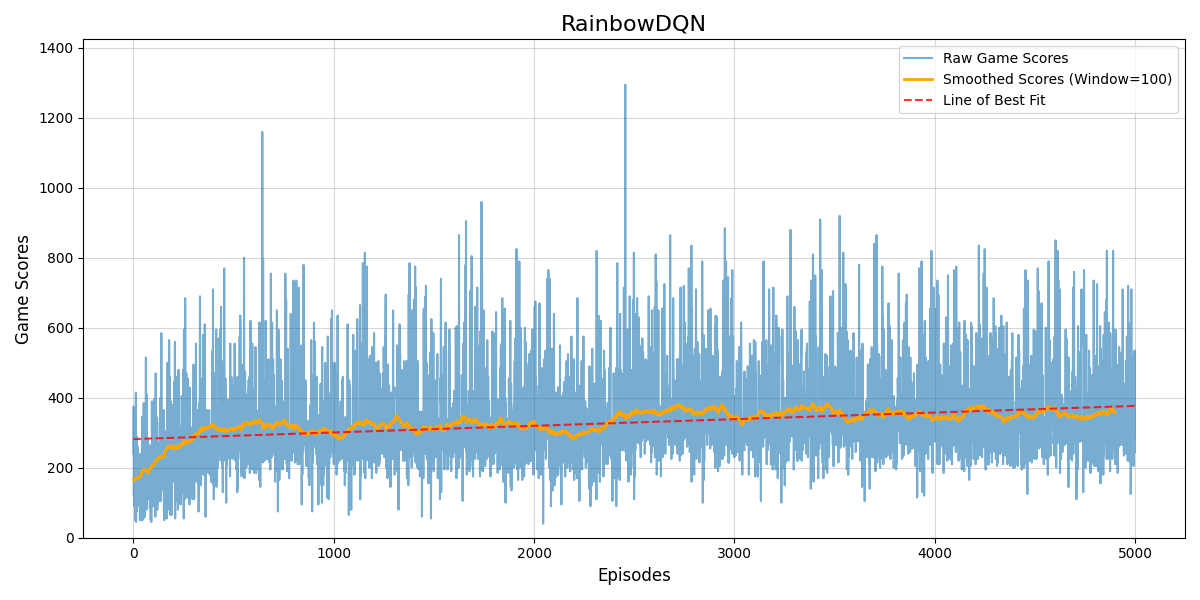 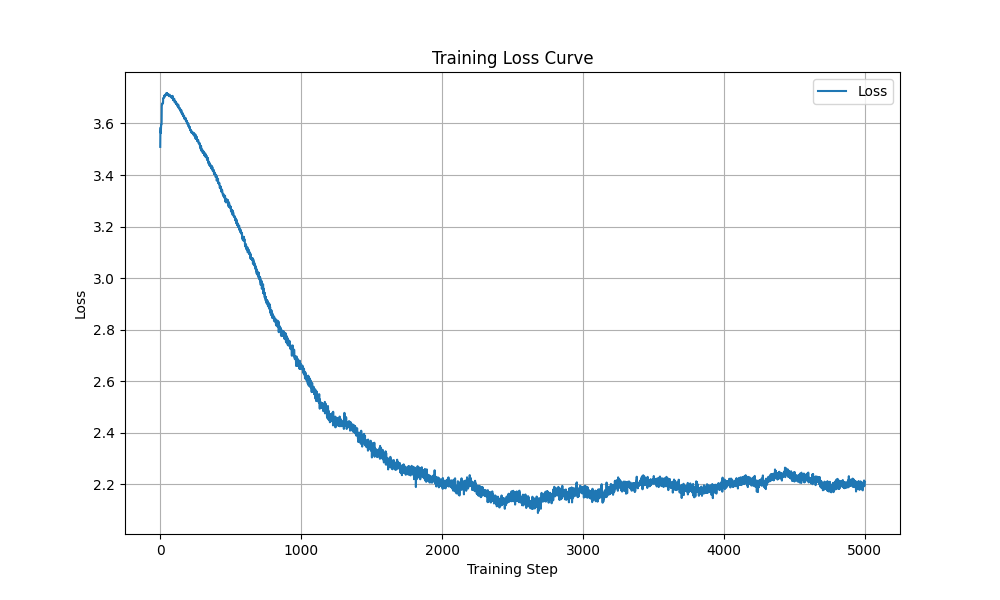 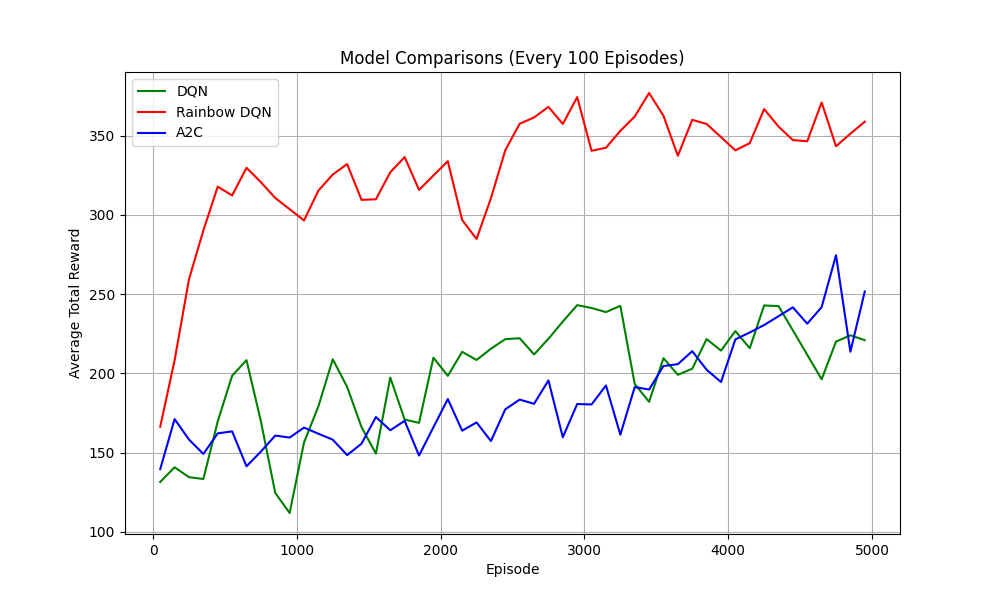